In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ОИАД. Лабораторная работа №2
## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 столбика данных по формулам:
1) $N \% 5$
2) $N^2 \% 5 + 5$
где $N$ - номер в списке


In [8]:
N = 21
col1 = N % 5
col2 = (N**2 % 5) + 5

print(f"Номер первой колонки: {col1}")
print(f"Номер второй колонки: {col2}")

df = pd.read_csv('../datasets/students_simple.csv')
x = df.iloc[:, col1]
y = df.iloc[:, col2]

Номер первой колонки: 1
Номер второй колонки: 6


## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [ ]:
from scipy import stats
from math import sqrt

def fechner_corr(x, y):
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_dev = np.sign(x - x_mean)
    y_dev = np.sign(y - y_mean)
    return np.sum(x_dev * y_dev) / len(x)

corr_fechner = fechner_corr(x, y)
corr_pearson = stats.pearsonr(x, y).correlation


n = len(x)
alpha = 0.05  # 95% доверительный интервал
z = np.arctanh(corr_pearson)
se = 1 / sqrt(n - 3)
z_crit = stats.norm.ppf(1 - alpha/2)
ci_low = np.tanh(z - z_crit * se)
ci_high = np.tanh(z + z_crit * se)

corr_spearman = stats.spearmanr(x, y).correlation
corr_kendall = stats.kendalltau(x, y).correlation
print(f"Фехнера: {corr_fechner:.3f}")
print(f"Пирсона: {corr_pearson:.3f} ")
print(f"95% доверительный интервал: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"Спирмена: {corr_spearman:.3f}")
print(f"Кенделла: {corr_kendall:.3f}")

Фехнера: -0.900
Пирсона: -0.961 
95% доверительный интервал: [-0.9846, -0.9012]
Спирмена: -0.985
Кенделла: -0.939


Все коэффициенты отрицательные и очень близки к -1, значит между столбцами наблюдается сильная обратная корреляция - при увеличении одной переменной другая уменьшается.

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

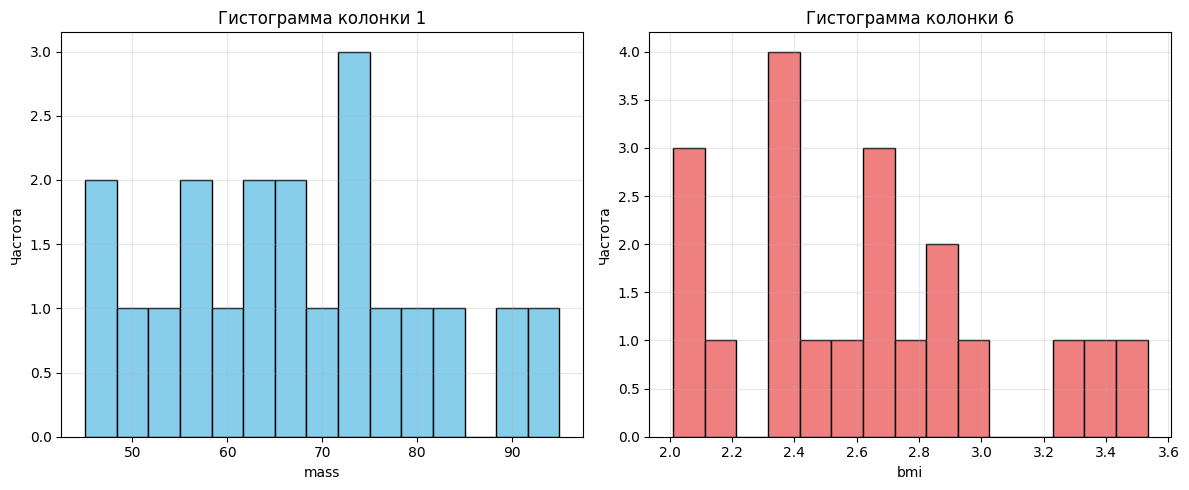

In [13]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x, bins=15, color='skyblue', edgecolor='black')
plt.title(f"Гистограмма колонки {col1}")
plt.xlabel(df.columns[col1])
plt.ylabel("Частота")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(y, bins=15, color='lightcoral', edgecolor='black')
plt.title(f"Гистограмма колонки {col2}")
plt.xlabel(df.columns[col2])
plt.ylabel("Частота")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


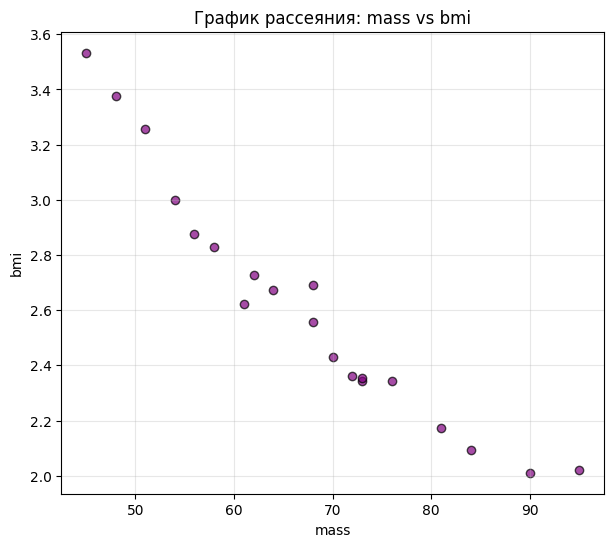

In [15]:
plt.figure(figsize=(7, 6))
plt.scatter(x, y, color='purple', edgecolor='black', alpha=0.7)
plt.title(f"График рассеяния: {df.columns[col1]} vs {df.columns[col2]}")
plt.xlabel(df.columns[col1])
plt.ylabel(df.columns[col2])
plt.grid(alpha=0.3)

plt.show()


Точки на графике рассеяния примерно ложатся на нисходящую прямую, что закономерно полученной нами корреляции. Это индикатор отрицательной зависимости. То есть чем больше первая величина, тем вторая меньше. 

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

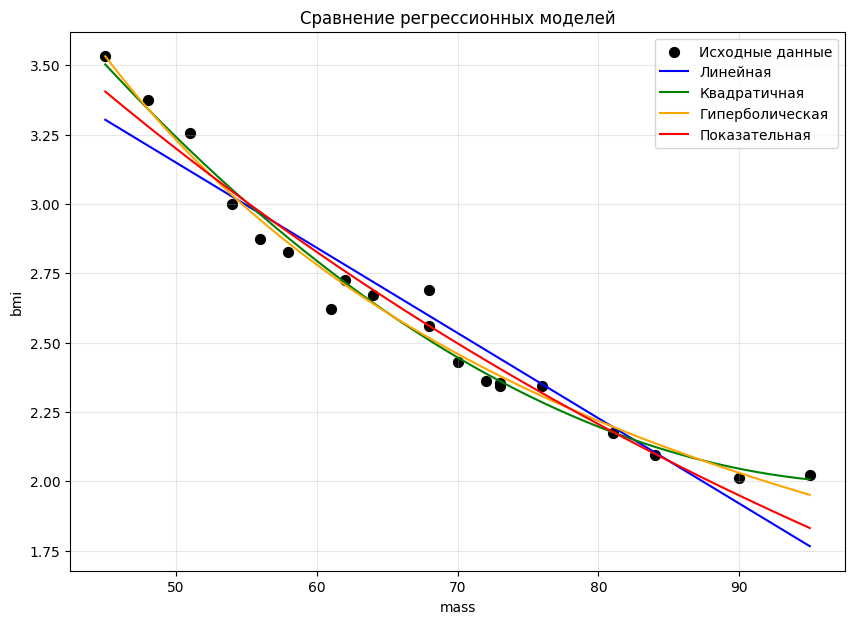

In [19]:
from scipy.optimize import curve_fit

def linear(x, w1, w0): return w1*x + w0
def quadratic(x, w2, w1, w0): return w2*x**2 + w1*x + w0
def hyperbolic(x, w1, w0): return w1/x + w0
def exponential(x, w1, w0): return w0 * (w1**x)

lin, _ = curve_fit(linear, x, y)
quad, _ = curve_fit(quadratic, x, y)
hyper, _ = curve_fit(hyperbolic, x, y)
exp, _ = curve_fit(exponential, x, y)

x_fit = np.linspace(min(x), max(x), 200)

y_linear = linear(x_fit, *lin)
y_quadratic = quadratic(x_fit, *quad)
y_hyperbolic = hyperbolic(x_fit, *hyper)
y_exponential = exponential(x_fit, *exp)

plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='black', s=50, label='Исходные данные')

plt.plot(x_fit, y_linear, color='blue', label=f'Линейная')
plt.plot(x_fit, y_quadratic, color='green', label=f'Квадратичная')
plt.plot(x_fit, y_hyperbolic, color='orange', label='Гиперболическая')
plt.plot(x_fit, y_exponential, color='red', label='Показательная')

plt.xlabel(df.columns[col1])
plt.ylabel(df.columns[col2])
plt.title('Сравнение регрессионных моделей')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

In [31]:
models = {
    "Линейная": (linear, lin),
    "Квадратичная": (quadratic, quad),
    "Гиперболическая": (hyperbolic, hyper),
    "Показательная": (exponential, exp)
}

results = {}
for name, (func, params) in models.items():
    y_pred = func(x, *params)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    R2 = 1 - ss_res / ss_tot
    k = len(params)
    F = (R2 / k) / ((1 - R2) / (n - k - 1))
    results[name] = (R2, F)

print("Модель | R² | F ")
print("-" * 40)
for name, (R2, F) in results.items():
    print(f"{name:15s} | {R2:6.4f} | {F:8.3f}")

best = max(results.items(), key=lambda x: x[1][0])
worst = min(results.items(), key=lambda x: x[1][0])


print("\n Лучшая модель:", best[0])
print(" Худшая модель:", worst[0])

alpha = 0.05
for label, (R2, F) in [best, worst]:
    k = len(models[label][1])
    F_crit = stats.f.ppf(1 - alpha, k, n - k - 1)
    print(f"\nМодель: {label}")
    print(f"F = {F:.3f}, F_кр = {F_crit:.3f}")
    if F > F_crit:
        print("Модель статистически значима")
    else:
        print("Модель незначима")

Модель | R² | F 
----------------------------------------
Линейная        | 0.9228 |  101.562
Квадратичная    | 0.9779 |  236.325
Гиперболическая | 0.9791 |  398.837
Показательная   | 0.9572 |  190.067

 Лучшая модель: Гиперболическая
 Худшая модель: Линейная

Модель: Гиперболическая
F = 398.837, F_кр = 3.592
Модель статистически значима

Модель: Линейная
F = 101.562, F_кр = 3.592
Модель статистически значима
